Here, I try to simulate the patterns obtained on a sandy terrain. This is what is observed when the wind blows on the dry surface of a land with sand or also on the surface of the sea in the presence of currents.

As described in https://en.wikipedia.org/wiki/Dune, 

> When a sandy seabed is subject to wave action and the wave orbital motion is strong enough to move sand grains, ripples often appear. The ripples induced by wave action are called “wave ripples”; their characteristics being different from those of the ripples generated by steady flows. The most striking difference between wave ripple fields and current ripple fields is the regularity of the former. Indeed, regular long-crested wave ripple fields are often observed on tidal beaches from which the sea has withdrawn at low water (see figure 1). 

A nice example is shown in http://www.coastalwiki.org/wiki/Wave_ripple_formation showing

> Ripples observed at Sea Rim State Park, along the coast of east Texas close to the border with Louisiana (courtesy by Zoltan Sylvester).
![](http://www.coastalwiki.org/w/images/6/65/WaveRippleFormationFig0.jpg)

[Wave ripple formation](http://www.coastalwiki.org/wiki/Wave_ripple_formation)

An interesting aspect of that patterns is that they may occur at different scales, like taht example on the surface of the Mars planet:

> Overview of large sand wave field and high-resolution difference map of two surveys approximately 21 hours apart illustrating both large-scale and small-scale sand wave migration and orientation. Migration is from right to left.

![](https://www.researchgate.net/profile/Daniel-Hanes/publication/252161559/figure/fig1/AS:669991225552924@1536749764962/Overview-of-large-sand-wave-field-and-high-resolution-difference-map-of-two-surveys.png)


<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
import matplotlib
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
#%config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 13
figsize = (fig_width, fig_width/phi)
subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
from IPython.display import display, HTML
def show_video(filename): 
    return HTML(data='<video src="{}" loop autoplay width="600" height="600"></video>'.format(filename))
%load_ext autoreload
%autoreload 2

## Wave & wind ripples

Such ripples can be charcterized using the physical process that generate them: 

> Sea waves shape the bottom and generate different morphological patterns, which are characterized by a wide range of length scales. The ripples are the smallest bedforms but, notwithstanding their relatively small size, they play a prominent role in many transport processes. Indeed, usually, the flow separates at their crests and vortices are generated which increase momentum transfer, sediment transport and, in general, mixing phenomena.  (from http://www.coastalwiki.org/wiki/Wave_ripples)

And can be formalized using simple iterative process like that described in http://nishitalab.org/user/nis/cdrom/pg/onoue.pdf or a more complex example shown in https://www.hindawi.com/journals/jam/2014/590358/

We will try to give a simple formulation and first initialize the parameters:

In [2]:
from dataclasses import dataclass, asdict
DEBUG = 2
DEBUG = 1

@dataclass
class Params:
    bins: int = 2**(8//DEBUG)
    N_particles: int = 2**(8*2) * 2**3
    N_step: int = 2**(10//DEBUG)
    L: float = 1 / 2**5 # saltation step in the y direction
    D: float = 1 / 2**2 # diffusion per step
    kappa: float = 10.
    seed : int = 1998

p = Params()
p

Params(bins=256, N_particles=524288, N_step=1024, L=0.03125, D=0.25, kappa=10.0, seed=1998)

The dynamical system can be simplified in the following code:

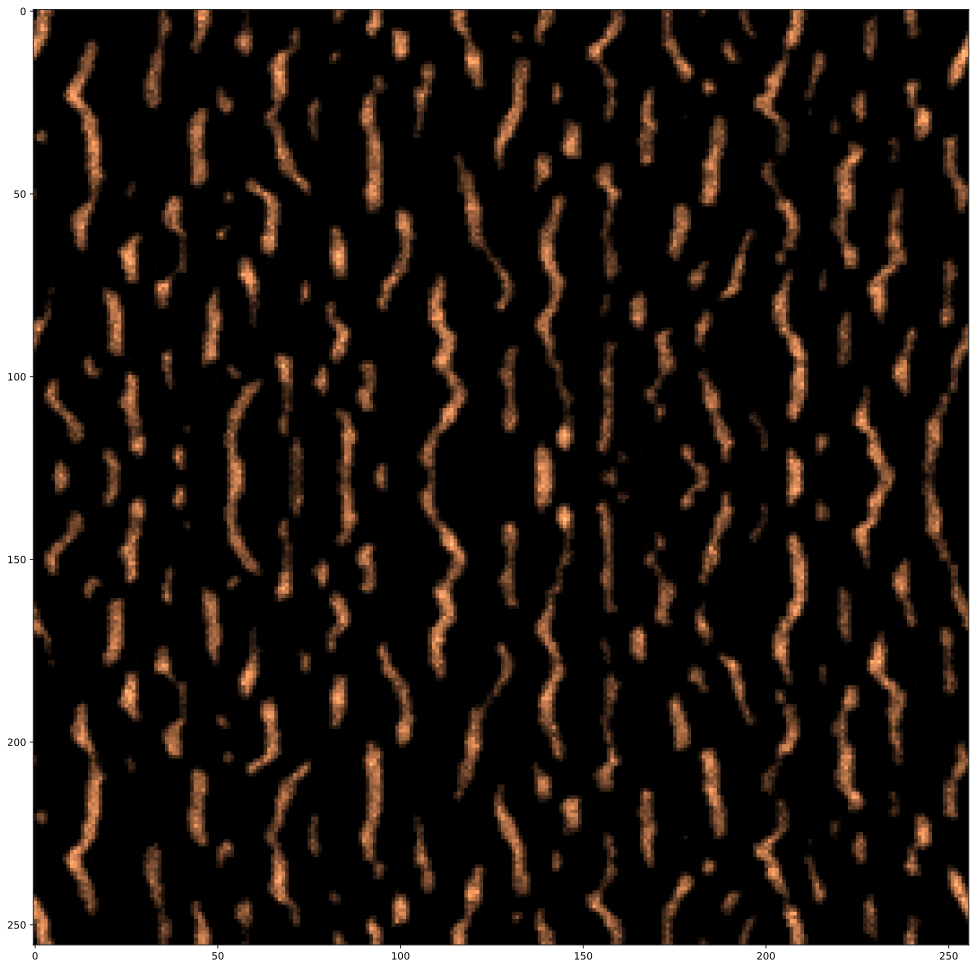

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def wind_ripples(p):

    binz = [np.linspace(0, 1, p.bins+1, endpoint=True), np.linspace(0, 1, p.bins+1, endpoint=True)]
    np.random.seed(p.seed)
    x, y = np.random.rand(p.N_particles), np.random.rand(p.N_particles)

    for i_step in range(p.N_step):
        
        x, y = x + p.D/(i_step+1)*np.random.randn(p.N_particles), y + p.D/(i_step+1)*np.random.randn(p.N_particles)    
        x, y = x % 1, y % 1

        height, edge_x, edge_y = np.histogram2d(x, y, bins=binz, density=True)
        
        ind_x, ind_y = (x*p.bins).astype(int), (y*p.bins).astype(int)

        y += p.L * sigmoid( - p.kappa * height[ind_x, ind_y])

    return height

height = wind_ripples(Params())
fig, ax = plt.subplots(figsize=(fig_width, fig_width), subplotpars=subplotpars)
ax.imshow(height, vmin=0, vmax=height.max(), cmap=plt.copper());    

Let's try to modify some parameters to see their effect on the obtained patterns:

In [5]:
N_scan = 5

In [6]:
def scan(variable, values):
    print(f'Scanning {variable=} along {values=}')
    N_scan = len(values)
    fig, axs = plt.subplots(1, N_scan, figsize=(fig_width, fig_width/N_scan), subplotpars=subplotpars)
    for i_scan in range(N_scan):
        scan_dict = {variable: values[i_scan]}
        height = wind_ripples(Params(**scan_dict))
        ax = axs[i_scan]
        ax.imshow(height, cmap=plt.copper())  
        ax.set_title(f'{variable}={values[i_scan]:.2e}')
        ax.axis('off')
    return fig, axs


Scanning variable='kappa' along values=array([ 0.1     ,  0.316228,  1.      ,  3.162278, 10.      ])


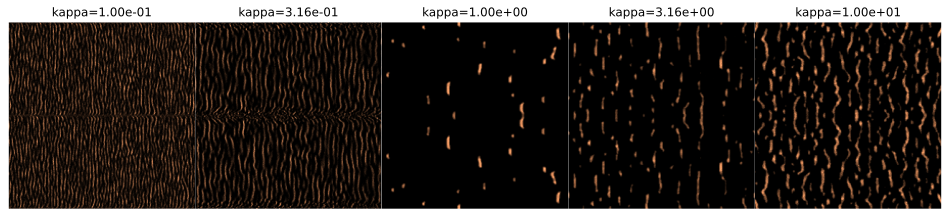

In [7]:
fig, axs = scan('kappa', 10. * np.logspace(-2, 0, N_scan, base=10));

Scanning variable='N_step' along values=array([   8,   64,  512, 4096])


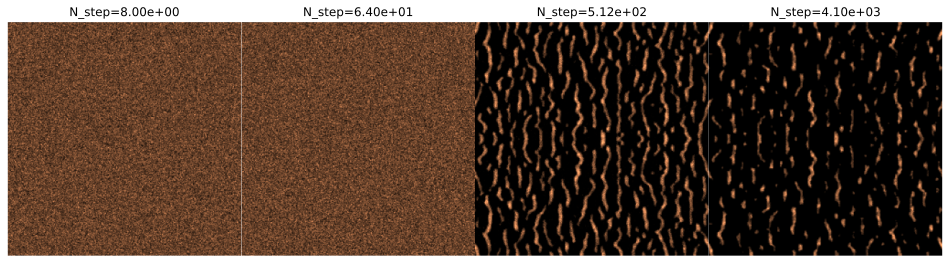

In [8]:
fig, axs = scan('N_step', 2**np.arange(3, 3*N_scan, 3, dtype=int));

Scanning variable='bins' along values=array([ 32,  64, 128, 256, 512])


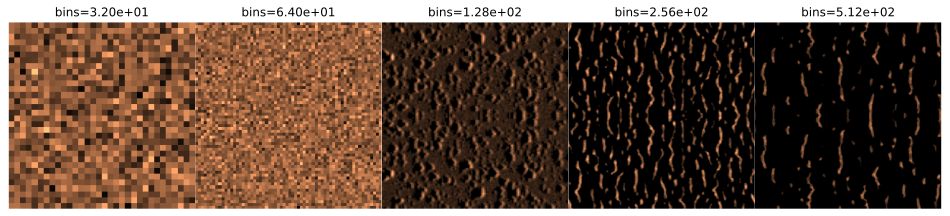

In [9]:
fig, axs = scan('bins', 2**np.arange(5, N_scan+5, dtype=int));

Scanning variable='N_particles' along values=array([ 131072,  262144,  524288, 1048576, 2097152])


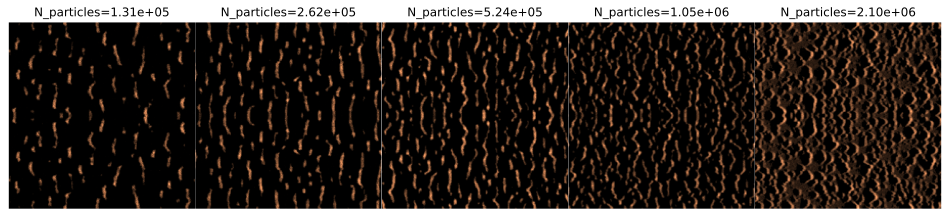

In [10]:
fig, axs = scan('N_particles', (p.bins)**2 * 2**np.arange(1, N_scan+1, dtype=int));

Scanning variable='D' along values=array([ 0.0025,  0.025 ,  0.25  ,  2.5   , 25.    ])


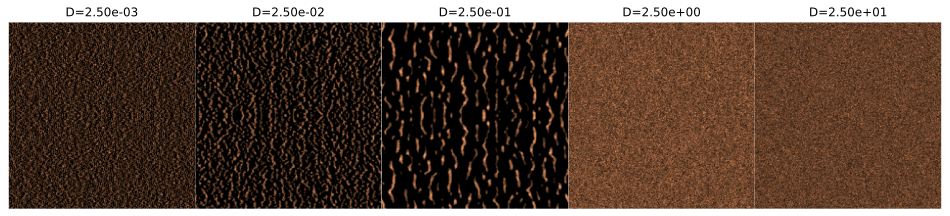

In [11]:
fig, axs = scan('D', p.D * np.logspace(-2, 2, N_scan, base=10));

Scanning variable='L' along values=array([0.007812, 0.018581, 0.044194, 0.105112, 0.25    ])


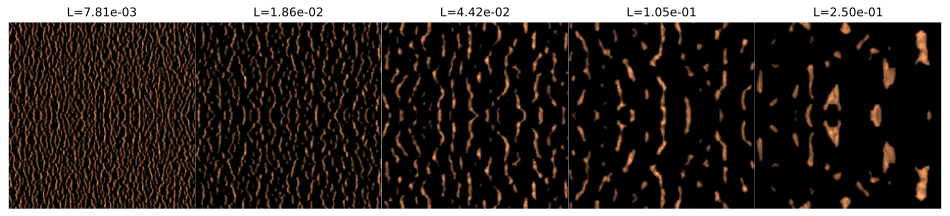

In [12]:
fig, axs = scan('L', np.geomspace(1 / 2**7, 1 / 2**2, N_scan));

## dune ripples

Dune ripples involve a slightly more complex model which can be defined as the following

In [13]:
@dataclass
class Params:
    bins: int = 2**(8//DEBUG)
    N_particles: int = 2**(8*2) * 2**3
    N_step: int = 2**(10//DEBUG)
    L: float = 1 / 2**5 # saltation step in the y direction
    D: float = 1 / 2**2 # diffusion per step
    b: float = 1 / 2**10
    kappa: float = 3
    seed : int = 1998

p = Params()
p

Params(bins=256, N_particles=524288, N_step=1024, L=0.03125, D=0.25, b=0.0009765625, kappa=3, seed=1998)

In [14]:
def gradient_y(image):
    image_ = image.copy()
    grad = np.roll(image_, shift=-1, axis=1)
    grad -= np.roll(image_, shift=1, axis=1)
    return grad
 

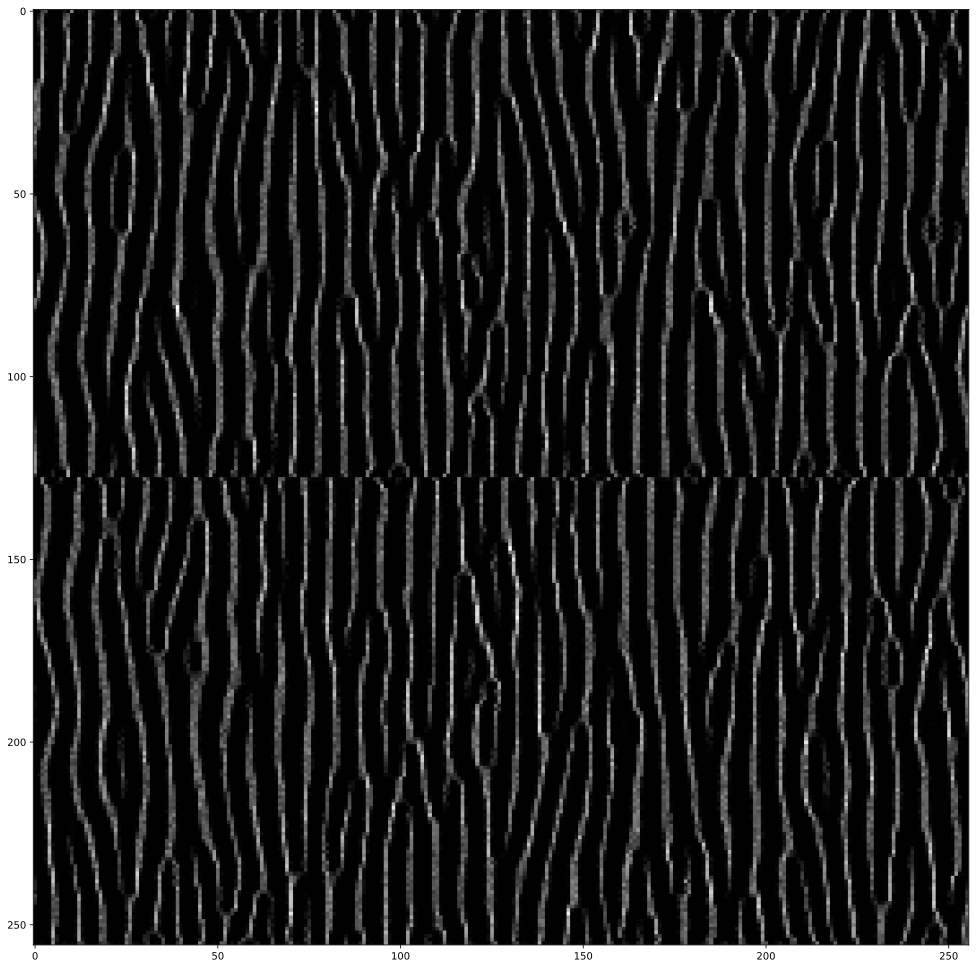

In [15]:

def dune_ripples(p):

    binz = [np.linspace(0, 1, p.bins+1, endpoint=True), np.linspace(0, 1, p.bins+1, endpoint=True)]
    np.random.seed(p.seed)
    x, y = np.random.rand(p.N_particles), np.random.rand(p.N_particles)

    for i_step in range(p.N_step):
        
        x, y = x + p.D/(i_step+1)*np.random.randn(p.N_particles), y + p.D/(i_step+1)*np.random.randn(p.N_particles)    
        # x, y = np.mod(x, 1), np.mod(y, 1)
        x, y = x % 1, y % 1

        height, edge_x, edge_y = np.histogram2d(x, y, bins=binz, density=True)
        slope = gradient_y(height)

        ind_x, ind_y = (x*p.bins).astype(int), (y*p.bins).astype(int)

        y += p.L + p.b * np.tanh( - p.kappa * slope[ind_x, ind_y])
        # y += L * np.sigmoid( - kappa * height[ind_x, ind_y]) # simpler rule to test

    return height, slope

height, slope = dune_ripples(Params())   

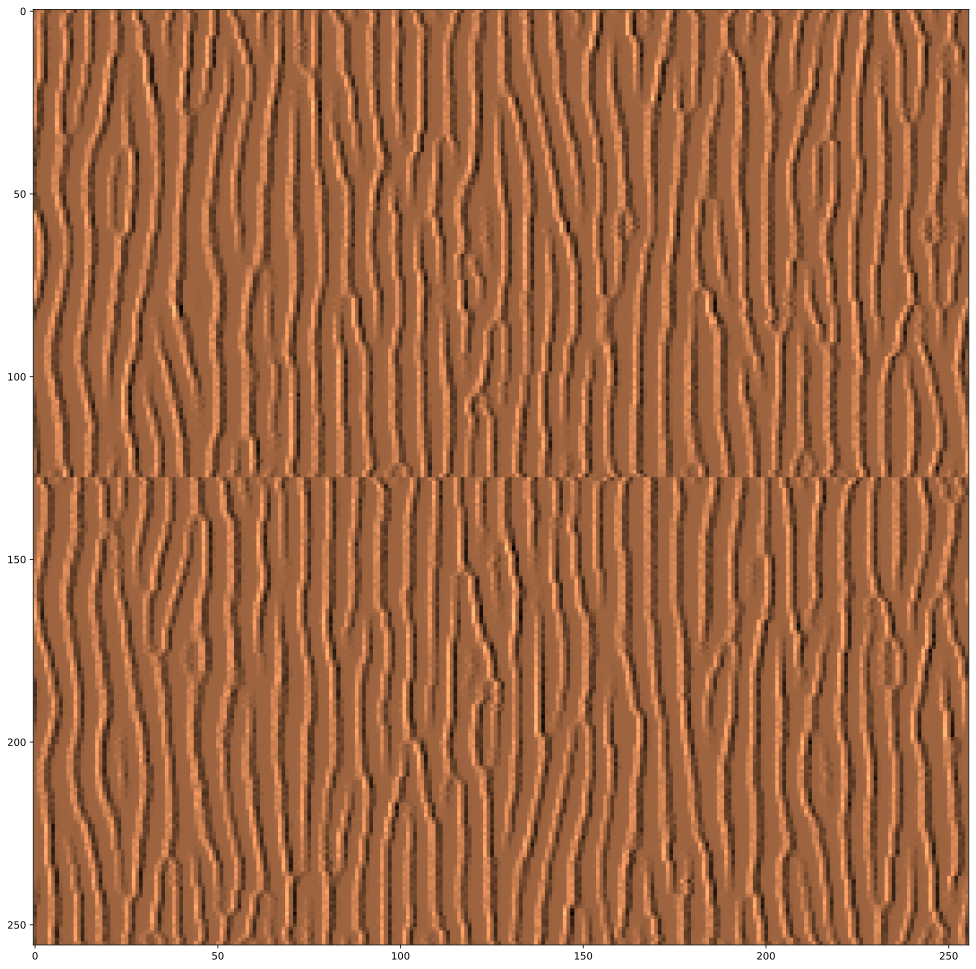

In [17]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width), subplotpars=subplotpars)
ax.imshow(slope, cmap=plt.copper());

In [18]:
def scan(variable, values):
    N_scan = len(values)
    fig, axs = plt.subplots(1, N_scan, figsize=(fig_width, fig_width/N_scan), subplotpars=subplotpars)
    for i_scan in range(N_scan):
        scan_dict = {variable: values[i_scan]}
        height, slope = dune_ripples(Params(**scan_dict))
        ax = axs[i_scan]
        ax.imshow(slope, cmap=plt.copper())  
        ax.set_title(f'{variable}={values[i_scan]:.2e}')
        ax.axis('off')

    return fig, axs


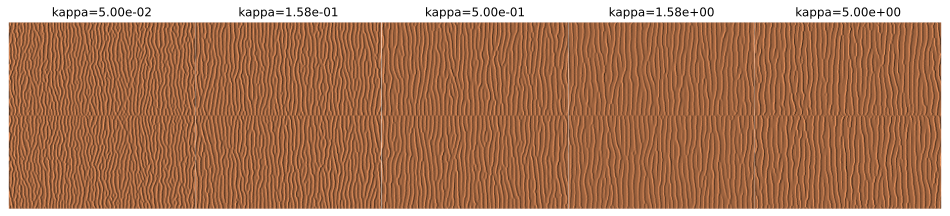

In [19]:
fig, axs = scan('kappa', 5. * np.logspace(-2, 0, N_scan, base=10));

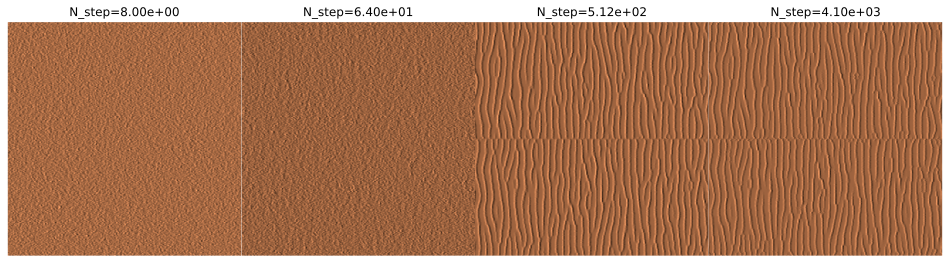

In [20]:
fig, axs = scan('N_step', 2**np.arange(3, 3*N_scan, 3, dtype=int));

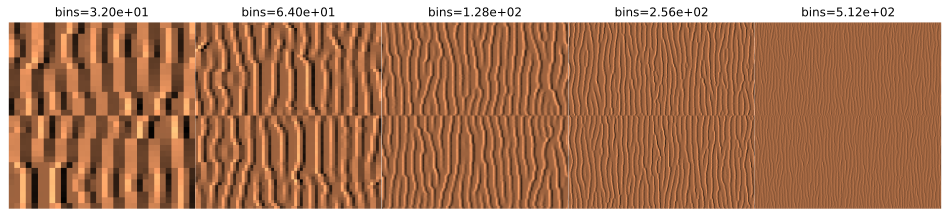

In [21]:
fig, axs = scan('bins', 2**np.arange(5, N_scan+5, dtype=int));

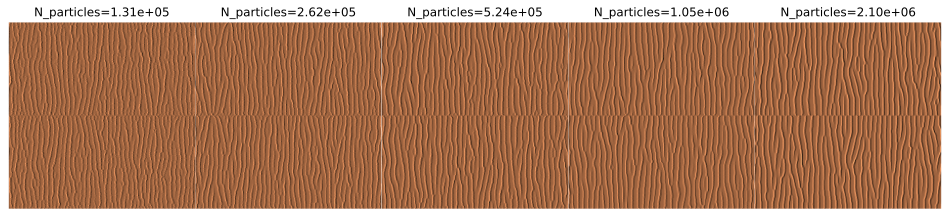

In [22]:
fig, axs = scan('N_particles', (p.bins)**2 * 2**np.arange(1, N_scan+1, dtype=int));

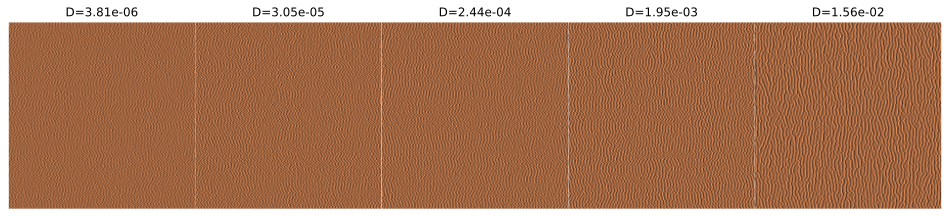

In [23]:
fig, axs = scan('D', np.geomspace(1 / 2**18, 1 / 2**6, N_scan));

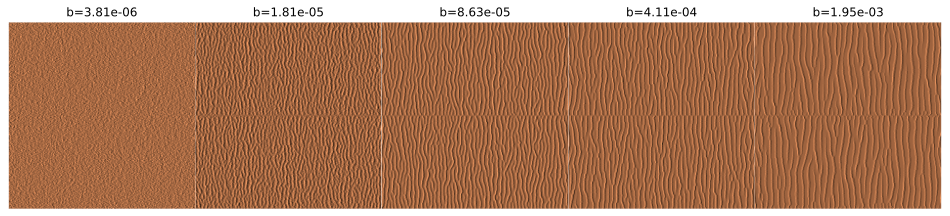

In [24]:
fig, axs = scan('b', np.geomspace(1 / 2**18, 1 / 2**9, N_scan));

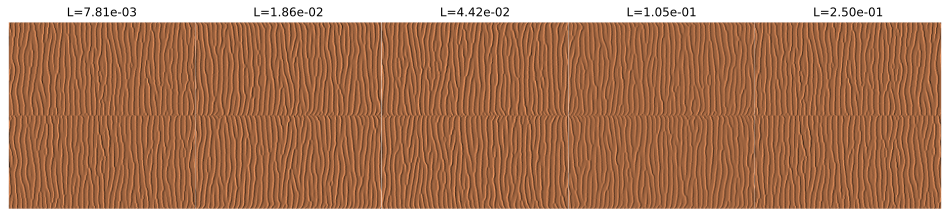

In [25]:
fig, axs = scan('L', np.geomspace(1 / 2**7, 1 / 2**2, N_scan));


As a conclusion, we could easily generate ripple and dune patterns. They form some class of reaction diffusion system, where the reaction is the accumulation of sand and the diffusion is the stronger effect of wind on differential areas of the pattern. 

## some book keeping for the notebook

In [26]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,scipy,pillow,imageio  -r -g -b

Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.11.0

numpy     : 1.24.2
matplotlib: 3.7.1
scipy     : 1.10.1
pillow    : not installed
imageio   : 2.27.0

Compiler    : Clang 14.0.0 (clang-1400.0.29.202)
OS          : Darwin
Release     : 22.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local

Git hash: 38554329cc1a2d4ad3a717bd572fcda36968918f

Git repo: https://github.com/laurentperrinet/sciblog.git

Git branch: master

